## Implementing Sequential Minimal Optimization algorithm for Support Vector Machines

Support Vector Machines is one of the most widely used Machine Learning algorithms for classification. It was formulated by Vladimir N. Vapnik and Alexey Ya. Chervonenkis in 1963.

The SVM problem is usually solved using SMO or Sequential Minimal Optimzation algorithm formulated by John Platt in 1998. Following implementation is a simplified version of the SMO. This is based on CS229 lecture notes by Andrew Ng [1].

Here I have used four datasets to demonstrate the working of the algorithm. And each hvae been classified using linear, 3rd degree polynomial and RBF kernels.

In [1]:
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
from random import randint
import scipy.io
import random
from sklearn.datasets import make_moons, make_circles, make_classification

In [2]:
%matplotlib inline

### Data 1

In [3]:
data_1=[]
with open("data_linear.csv") as f:
    reader = csv.reader(f)
    for row in reader:
        data_1.append(row)
    f.close()
    
data_1=np.array(np.vstack(data_1))
data_1=np.ndarray.astype(data_1,float)
data_1=data_1[np.random.randint(0,len(data_1),100),:]

### Data 2

In [4]:
data_2=[]
with open("data2.csv") as f:
    reader = csv.reader(f)
    for row in reader:
        data_2.append(row)
    f.close()
    
data_2=np.array(np.vstack(data_2))
data_2=np.ndarray.astype(data_2,float)
random.seed(1234)
data_2=data_2[np.random.randint(0,len(data_2),100),:]

### Data 3

In [5]:
data_3=[]
with open("spiral.csv") as f:
    reader = csv.reader(f)
    for row in reader:
        data_3.append(row)
    f.close()
    
data_3=np.array(np.vstack(data_3))
data_3=np.ndarray.astype(data_3,float)
random.seed(1234)

### Data 4

In [6]:
data_new=make_moons(noise=0.2, random_state=0)
data_4=data_new[0]

data_4=np.append(data_4,data_new[1].reshape(-1,1),axis=1)

tmp=data_4[:,1].copy()
data_4[:,1]=data_4[:,2].copy()
data_4[:,2]=tmp.copy()

tmp=data_4[:,0].copy()
data_4[:,0]=data_4[:,1].copy()
data_4[:,1]=tmp.copy()

for i in range(0,len(data_4)):
    if data_4[i,0]==0:
        data_4[i,0]=-1

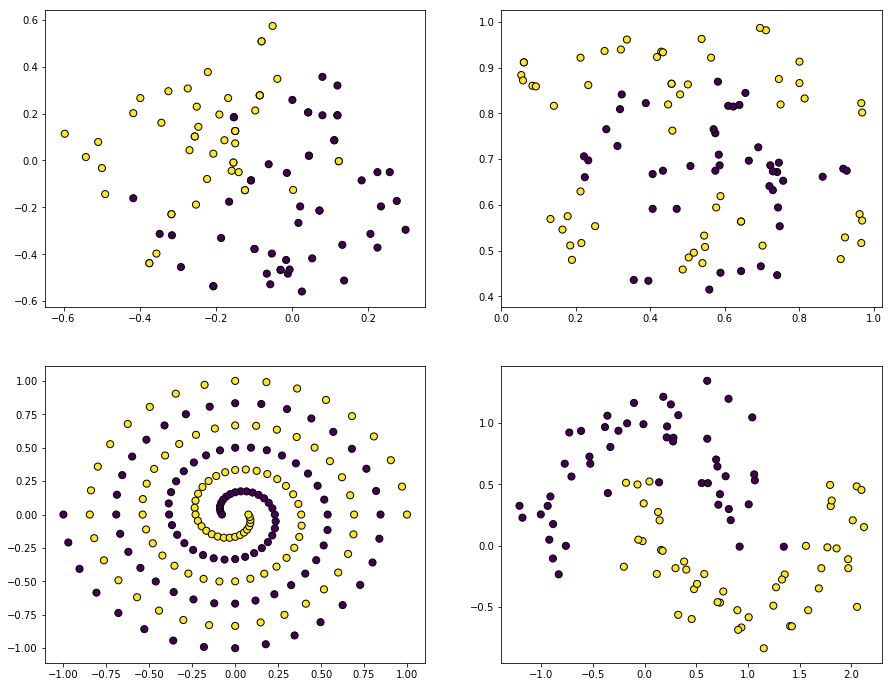

In [7]:
fig1, ax1 = plt.subplots(nrows=2, ncols=2,figsize=(15,12))
data=[data_1,data_2,data_3,data_4]
k=0
for row1 in ax1:
    for col1 in row1:
        col1.scatter(data[k][:,1],data[k][:,2],c=data[k][:,0],s=50,edgecolors='black')
        k+=1

In [8]:
def K(data,i,j,ker):
    gamma=100
    if ker=='rbf':
        return np.exp(-1*gamma*(data[i,(1,2)].dot(data[i,(1,2)])+data[j,(1,2)].dot(data[j,(1,2)])-2*data[i,(1,2)].dot(data[j,(1,2)]))) 
    
    if ker=='lin':
        return data[i,(1,2)].dot(data[j,(1,2)])
    
    if ker=='poly':
        return (data[i,(1,2)].dot(data[j,(1,2)])+1)**3

In [9]:
def func(alpha,data,p,ker):
    f1=0
    for i in range(0,len(data)):
        f1=f1+alpha[i]*data[i,0]*K(data,i,p,ker)
                                
    return f1

In [10]:
def calEk(alpha,data,i,ker):
    return func(alpha,data,i,ker)-data[i,0]

In [11]:
def SMO(data,ker):
    max_passes=1
    tol=1e-05
    C=0.1
    alpha=[0]*len(data)
    b=0
    passes=0
    loop=0
    while passes<max_passes:
        num_Changed_alphas=0
        for i in range(0,len(data)):    
            Ei=calEk(alpha,data,i,ker)
            if (data[i,0]*Ei<-tol and alpha[i]<C) or (data[i,0]*Ei>tol and alpha[i]>0):
                j=-1
                while True:
                    j=randint(0, len(data)-1)
                    if j!=i:
                        break
                Ej=calEk(alpha,data,j,ker)
                alpha_old_i=alpha[i]
                alpha_old_j=alpha[j]
                if data[i,0]!=data[j,0]:
                    L=max(0,alpha[j]-alpha[i])
                    H=min(C,C+alpha[j]-alpha[i])
                else:
                    L=max(0,alpha[j]+alpha[i]-C)
                    H=min(C,alpha[j]+alpha[i])

                if(L==H):
                    continue
                
                eta=2*K(data,i,j,ker)-K(data,i,i,ker)-K(data,j,j,ker)
                
                if(eta>=0):
                    continue
                    
                alpha[j]=alpha[j]-data[j,0]*(Ei-Ej)/eta
                
                if alpha[j]>H:
                    alpha[j]=H
                elif alpha[j]<=H and alpha[j]>=L:
                    alpha[j]=alpha[j]
                elif alpha[j]<L:
                    alpha[j]=L
                    
                if(abs(alpha[j]-alpha_old_j)<1e-05):
                    continue
                
                alpha[i]=alpha[i]+data[i,0]*data[j,0]*(alpha_old_j-alpha[j])
                
                b1=b-Ei-data[i,0]*(alpha[i]-alpha_old_i)*K(data,i,i,ker)-data[j,0]*(alpha[j]-alpha_old_j)*K(data,i,j,ker)
                
                b2=b-Ej-data[i,0]*(alpha[i]-alpha_old_i)*K(data,i,j,ker)-data[j,0]*(alpha[j]-alpha_old_j)*K(data,j,j,ker)
                
                if alpha[i]>0 and alpha[i]<C:
                    b=b1
                elif alpha[j]>0 and alpha[j]<C:
                    b=b2
                else:
                    b=(b1+b2)/2
                
                num_Changed_alphas=num_Changed_alphas+1   
        if(num_Changed_alphas==0):
            passes=passes+1
        else:
            passes=0
        
    
    return np.array(alpha),b

In [12]:
def K_c(data,i,z,ker):
    gamma=100
    if ker=='rbf':
        return np.exp(-1*gamma*(data[i,(1,2)].dot(data[i,(1,2)])+z.dot(z)-2*data[i,(1,2)].dot(z))) 
    
    if ker=='lin':
        return data[i,(1,2)].dot(z)
    
    if ker=='poly':
        return (data[i,(1,2)].dot(z)+1)**3
    
def func_c(alpha,data,z,ker):
    f1=0
    for i in range(0,len(data)):
        f1=f1+alpha[i]*data[i,0]*K_c(data,i,z,ker)
                                
    return f1

In [13]:
def return_w_b(data,ker):
    alpha_final,b_final=SMO(data,ker)
    alpha=alpha_final[alpha_final>1e-08]
    y=data[alpha_final>1e-08,0]
    x=[0,0]
    x[0]=data[alpha_final>1e-08,1]
    x[1]=data[alpha_final>1e-08,2]
    x=np.array(x)
    W=[0,0]
    for i in range(0,len(y)):
        W[0]=W[0]+alpha[i]*y[i]*x[0,i]
        W[1]=W[1]+alpha[i]*y[i]*x[1,i]
    W=np.array(W)
    b=np.mean(y-x.T.dot(W))
    
    return W,b,alpha,alpha_final

In [14]:
def plot_linear(data,W,b,alpha,alpha_final,col):
    col.scatter(data[:,1],data[:,2],c=data[:,0],s=100,edgecolors='black')
    xx=np.linspace(min(data[:,1])-1,max(data[:,1])+1,10)
    col.axis("tight")
    col.plot(xx,(-1*b-W[0]*xx)/W[1])

In [15]:
def plot_hyperplane(data,W,b,alpha,alpha_final,ker,col):
    if ker=='lin':
        plot_linear(data,W,b,alpha,alpha_final,col)
    
    else:
        xx = np.linspace(min(data[:,1])-0.1, max(data[:,1])+0.1, 50)
        yy = np.linspace(min(data[:,2])-0.1, max(data[:,2])+0.1, 50)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        data_sv=data[alpha_final>1e-08]
        pred=[0]*len(xy)
        for i in range(0,len(xy)):
            pred[i]=func_c(alpha,data_sv,xy[i,:],ker)
        pred=np.array(pred)
        if len(pred[pred<0])!=0:
            pred=np.sign(pred)
        else:
            for i in range(0,len(pred)):
                if pred[i]>=np.mean(pred):
                    pred[i]=1
                else:
                    pred[i]=-1

        Z=pred.reshape(XX.shape)
        col.contourf(XX, YY, Z,cmap=plt.cm.coolwarm,alpha=0.9)
        col.scatter(data[:,1], data[:,2],c=data[:,0],s=100,edgecolors='black')

### Classification using linear kernel

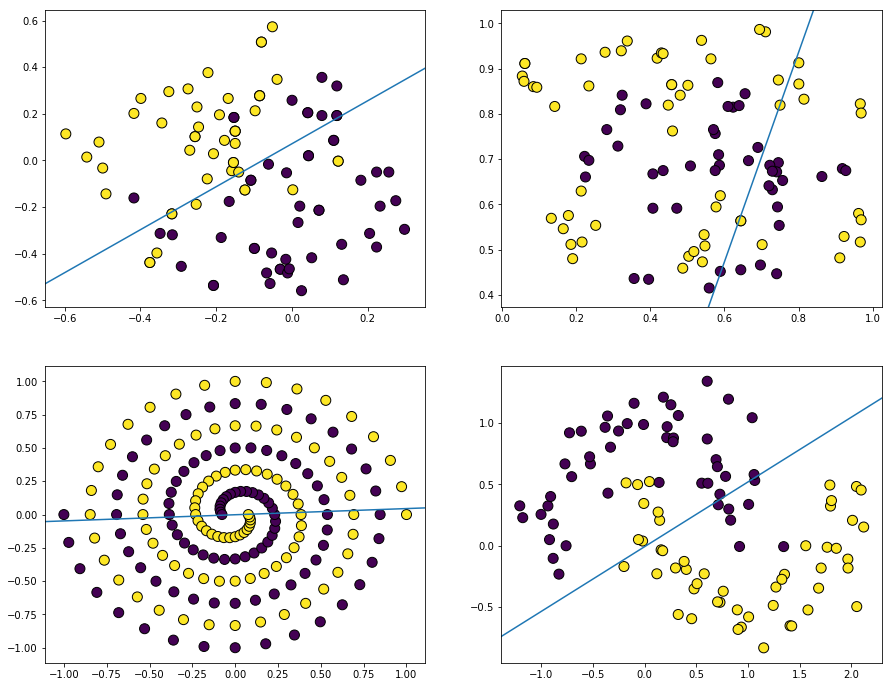

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15,12))
data=[data_1,data_2,data_3,data_4]
i=0
for row in ax:
    for col in row:
        kernel='lin'
        W,b,alpha,alpha_final=return_w_b(data[i],kernel)
        plot_hyperplane(data[i],W,b,alpha,alpha_final,kernel,col)
        i+=1

plt.show()

### Classification using 3rd dgree polynomial kernel

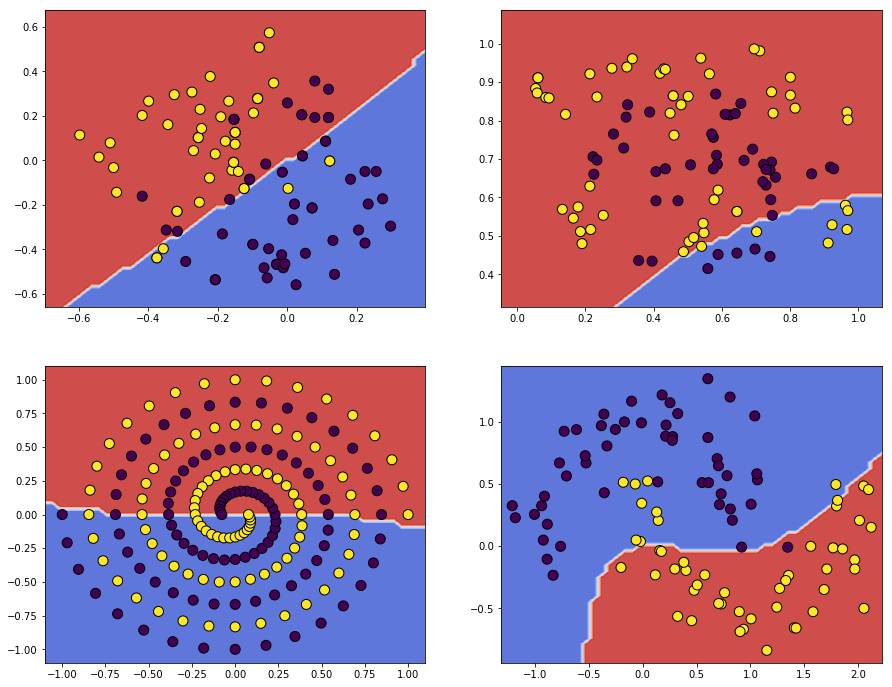

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15,12))
data=[data_1,data_2,data_3,data_4]
i=0
for row in ax:
    for col in row:
        kernel='poly'
        W,b,alpha,alpha_final=return_w_b(data[i],kernel)
        plot_hyperplane(data[i],W,b,alpha,alpha_final,kernel,col)
        i+=1

plt.show()

### Classification using RBF kernel

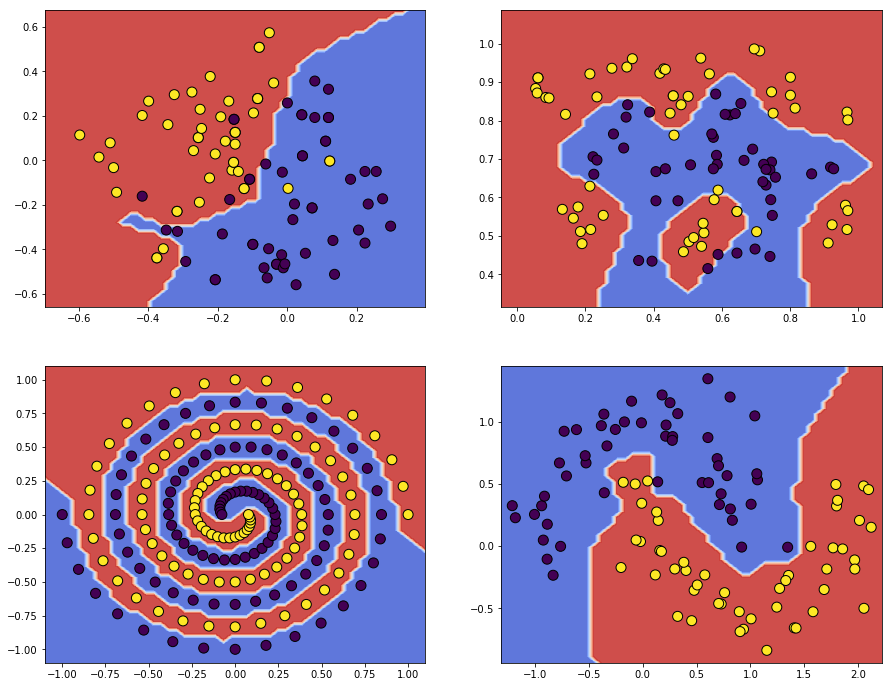

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15,12))
data=[data_1,data_2,data_3,data_4]
i=0
for row in ax:
    for col in row:
        kernel='rbf'
        W,b,alpha,alpha_final=return_w_b(data[i],kernel)
        plot_hyperplane(data[i],W,b,alpha,alpha_final,kernel,col)
        i+=1

plt.show()